In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os

import numpy as np
import cv2

from keras.models import Model
from keras.layers import Input, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import concatenate
from keras.optimizers import Adam
from keras import backend as K

from skimage.measure import compare_psnr

Using TensorFlow backend.


In [2]:
import numpy as np

import tensorflow
import keras

from keras.models import Sequential, Model
from keras.engine.input_layer import Input
from keras.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Lambda, Concatenate

# credit to: https://github.com/sabakanation/DeepImagePrior
def reflection_padding(x, padding):
    reflected = Lambda(lambda x: x[:, :, ::-1, :])(x)
    reflected = Lambda(lambda x: x[:, :, :padding[1], :])(reflected)
    upper_row = concatenate([x, reflected], axis=2)
    lower_row = Lambda(lambda x: x[:, ::-1, :, :])(upper_row)
    lower_row = Lambda(lambda x: x[:, :padding[0], :, :])(lower_row)
    padded = concatenate([upper_row, lower_row], axis=1)
    return padded

def get_layer_size(x):
    height, width = x.get_shape()[1:3]
    height = int(height)
    width = int(width)
    return [height, width]

def Conv_BN_Act(layer, num_channels=128, kernel_size=3, strides=(1,1)):
    size = get_layer_size(layer)

    padding = [0, 0]
    padding[0] = (int(size[0]/strides[0]) - 1) * strides[0] + kernel_size - size[0]
    padding[1] = (int(size[1]/strides[1]) - 1) * strides[1] + kernel_size - size[1]
    layer = reflection_padding(layer, padding)

    layer = Conv2D(num_channels, kernel_size, strides=strides, padding='valid', activation=None)(layer)
    layer = BatchNormalization()(layer)
    layer = LeakyReLU(alpha=0.2)(layer)

    return layer

# mostly based on: https://github.com/beala/deep-image-prior-tensorflow
def down_layer(layer, num_channels=128, kernel_size=3):
    size = get_layer_size(layer)
    if size[0] % 2 != 0:
        layer = reflection_padding(layer, [1, 0])
    if size[1] % 2 != 0:
        layer = reflection_padding(layer, [0, 1])

    layer = Conv_BN_Act(layer, num_channels, kernel_size, (2, 2))
    layer = Conv_BN_Act(layer, num_channels, kernel_size, (1, 1))
    
    return layer

def up_layer(layer, num_channels=128, kernel_size=3, inter="bilinear"):
    layer = UpSampling2D(size=(2, 2))(layer)

    if inter == "bilinear":
        layer_padded = reflection_padding(layer, (1, 1))
        layer = Lambda(lambda x: (x[:, :-1, 1:, :] + x[:, 1:, :-1, :] + x[:, :-1, :-1, :] + x[:, :-1, :-1, :]) / 4.0)(layer_padded)

    layer = Conv_BN_Act(layer, num_channels, kernel_size, (1, 1))
    layer = Conv_BN_Act(layer, num_channels, 1, (1, 1))
    
    return layer

def skip(layer, num_channels=4, kernel_size=1):
    layer = Conv_BN_Act(layer, num_channels, kernel_size, (1, 1))
    return layer

def build_model(input_shape, num_depth, down_channels, up_channels, down_kernel, up_kernel, skip_channel, skip_kernel, inter):
    input_layer = Input(shape=input_shape)

    # Connect up all the downsampling layers.
    skips = []
    layer = input_layer
    size = get_layer_size(layer)
    sizes = [size]
    for i in range(num_depth):
        layer = down_layer(layer, down_channels[i], down_kernel[i])
        size = get_layer_size(layer)
        sizes.append(size)
        if skip_channel[i] != 0:
            skips.append(skip(layer, skip_channel[i], skip_kernel[i]))
        else:
            skips.append(None)
    print("Shape after downsample: " + str(layer.get_shape()))

    # Connect up the upsampling layers, from smallest to largest.
    for i in range(num_depth-1, -1, -1):
        if skip_channel[i] != 0:
            layer = concatenate([layer, skips[i]], axis=3)
        layer = up_layer(layer, up_channels[i], up_kernel[i], inter)
        size = get_layer_size(layer)

        if sizes[i] != size:
            layer = Lambda(lambda x: x[:, :sizes[i][0], :sizes[i][1], :])(layer)

    print("Shape after upsample: " + str(layer.get_shape()))

    # Restore original image dimensions and channels
    output_layer = Conv2D(3, 1, strides=1, padding='valid', activation=None)(layer)
    print("Output shape: " + str(output_layer.get_shape()))
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [3]:
def squared_error(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true))

def define_denoising_model(height, width):
    input_shape = (height, width, 32)
    num_depth = 5
    up_channels = [128, 128, 128, 128, 128]
    down_channels = [128, 128, 128, 128, 128]
    up_kernel = [3, 3, 3, 3, 3]
    down_kernel = [3, 3, 3, 3, 3]
    skip_channel = [4, 4, 4, 4, 4]
    skip_kernel = [1, 1, 1, 1, 1]
    lr = 0.01
    inter = "bilinear"
    
#     model = define_model(num_u, num_d, kernel_u, kernel_d, num_s, kernel_s, height, width, inter, lr)
    model = build_model(input_shape, num_depth, down_channels, up_channels, down_kernel, up_kernel, skip_channel, skip_kernel, inter)
    model.compile(loss=squared_error, optimizer=Adam(lr=lr))

    return model


# def denoising(image):
#     height, width = image.shape[:2]
#     model = define_denoising_model(height, width)
#     input_noise = np.random.uniform(0, 0.1, (1, height, width, 32))

#     for i in range(1800):
#         model.train_on_batch(input_noise + np.random.normal(0, 1/30.0, (height, width, 32)), image[None, :, :, :])

#     return np.clip(model.predict(input_noise)[0], 0, 255).astype(np.uint8)



In [4]:
fname = 'data/denoising/kodim03.png'
image = cv2.imread(fname)

In [5]:
height, width = image.shape[:2]
image_noisy = np.clip((image/225. + np.random.normal(0, 1/30.0, (height, width, 3)))*255, 0, 255).astype(np.uint8)

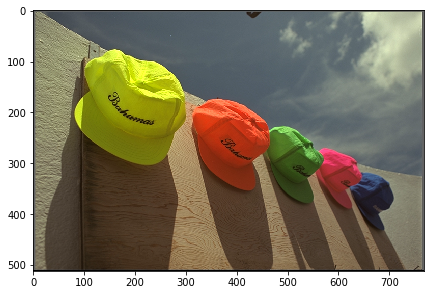

In [11]:
plt.figure(figsize=(7, 7))
plt.imshow(image[:,:,::-1])
plt.show()

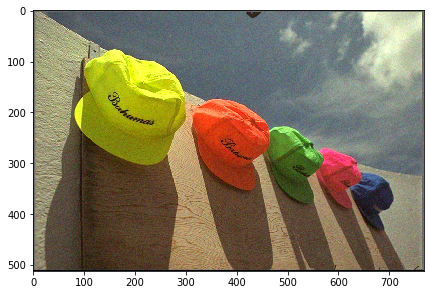

In [7]:
plt.figure(figsize=(7, 7))
plt.imshow(image_noisy[:,:,::-1])
plt.show()

In [11]:
model = define_denoising_model(height, width)
input_noise = np.random.uniform(0, 0.1, (1, height, width, 32))

Shape after downsample: (?, 16, 24, 128)
Shape after upsample: (?, 512, 768, 128)
Output shape: (?, 512, 768, 3)


In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 768, 32) 0                                            
__________________________________________________________________________________________________
lambda_126 (Lambda)             (None, 512, 768, 32) 0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_127 (Lambda)             (None, 512, 1, 32)   0           lambda_126[0][0]                 
__________________________________________________________________________________________________
concatenate_66 (Concatenate)    (None, 512, 769, 32) 0           input_2[0][0]                    
                                                                 lambda_127[0][0]                 
__________

Iter # 0 , PSRN NOISY:  6.4431507177287015 ; PSRN GT:  7.446207751066808


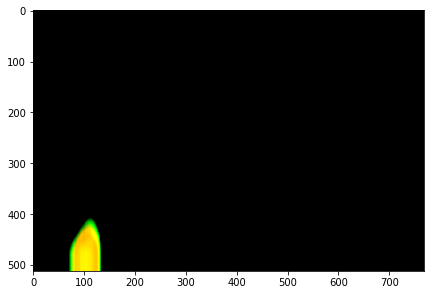

Iter # 20 , PSRN NOISY:  7.227081578555376 ; PSRN GT:  8.227499757835204


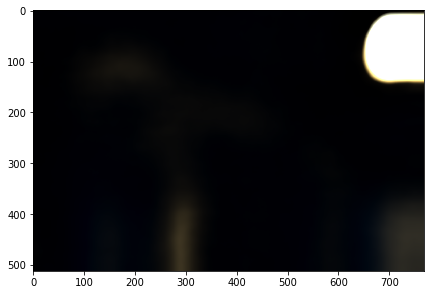

Iter # 40 , PSRN NOISY:  9.435644924621524 ; PSRN GT:  8.794010130257867


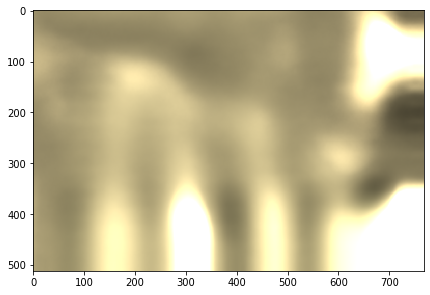

Iter # 60 , PSRN NOISY:  6.104002164399179 ; PSRN GT:  5.434002793918453


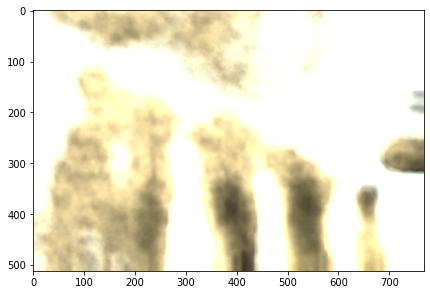

Iter # 80 , PSRN NOISY:  7.90020226105118 ; PSRN GT:  7.152309283047247


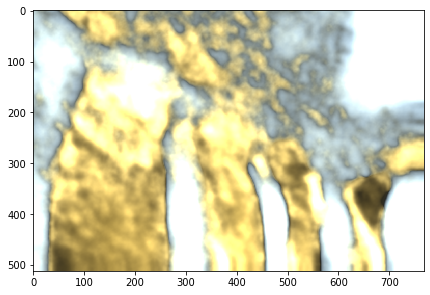

Iter # 100 , PSRN NOISY:  12.62796566644215 ; PSRN GT:  11.550967685651363


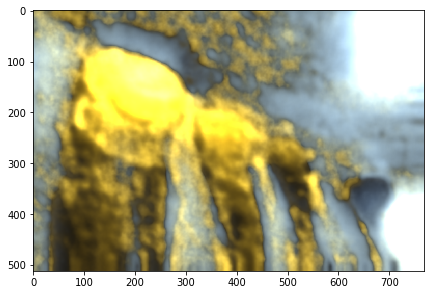

Iter # 120 , PSRN NOISY:  14.526376198520943 ; PSRN GT:  13.875847594945688


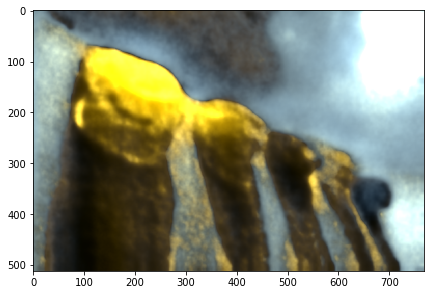

Iter # 140 , PSRN NOISY:  15.928573124840835 ; PSRN GT:  14.838588007301345


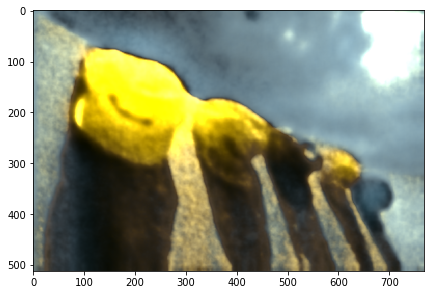

Iter # 160 , PSRN NOISY:  16.786093115685496 ; PSRN GT:  15.752163022093002


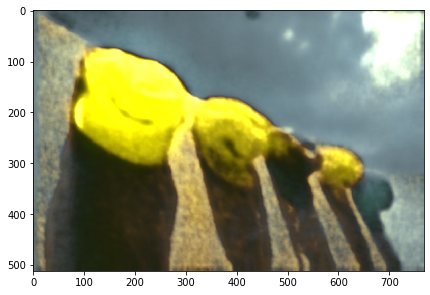

Iter # 180 , PSRN NOISY:  17.5586458620348 ; PSRN GT:  17.01722150017456


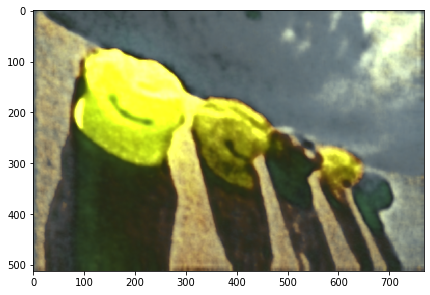

Iter # 200 , PSRN NOISY:  18.365242634282314 ; PSRN GT:  19.573406479715377


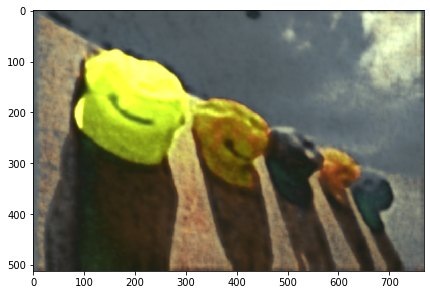

Iter # 220 , PSRN NOISY:  18.304391310916156 ; PSRN GT:  20.434548965501417


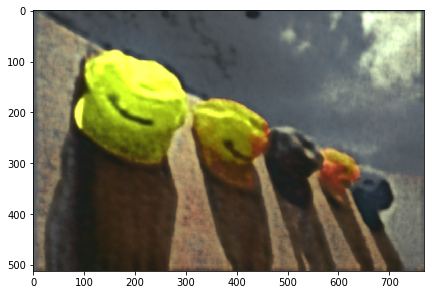

Iter # 240 , PSRN NOISY:  20.2159322310414 ; PSRN GT:  21.574334176302617


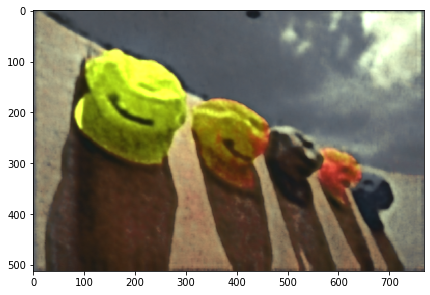

Iter # 260 , PSRN NOISY:  21.077902997911842 ; PSRN GT:  23.273809448975186


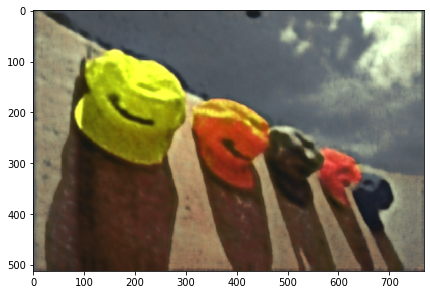

Iter # 280 , PSRN NOISY:  20.13405665453819 ; PSRN GT:  23.2229896318465


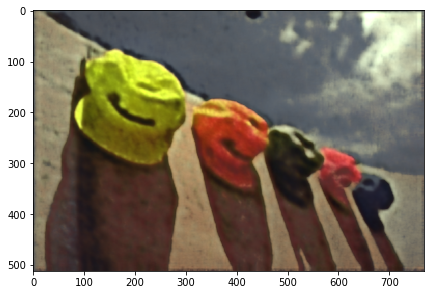

Iter # 300 , PSRN NOISY:  20.28124539616231 ; PSRN GT:  24.7895253469963


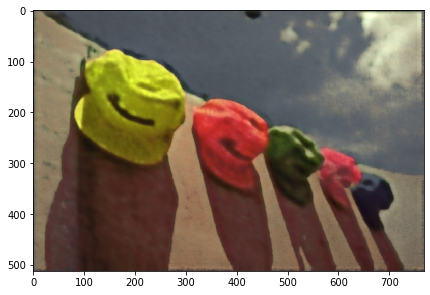

Iter # 320 , PSRN NOISY:  21.14541680580524 ; PSRN GT:  25.757269452507305


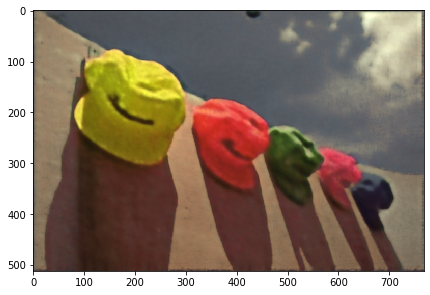

Iter # 340 , PSRN NOISY:  21.14490658784465 ; PSRN GT:  25.935437428730527


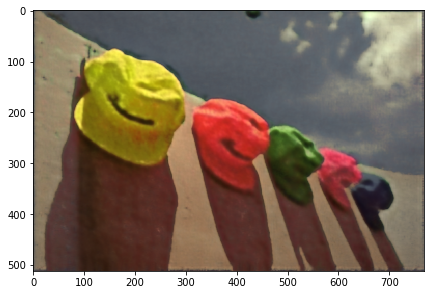

Iter # 360 , PSRN NOISY:  21.002221489323873 ; PSRN GT:  26.046633927148704


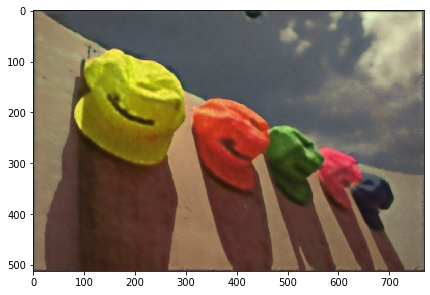

Iter # 380 , PSRN NOISY:  21.29384828223153 ; PSRN GT:  26.245584233836517


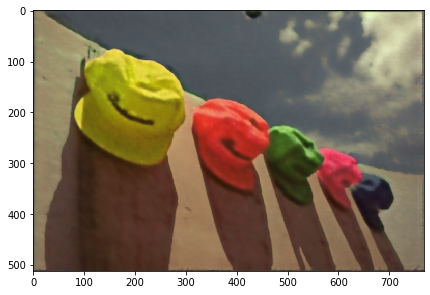

Iter # 400 , PSRN NOISY:  22.149967878993564 ; PSRN GT:  25.896960570374745


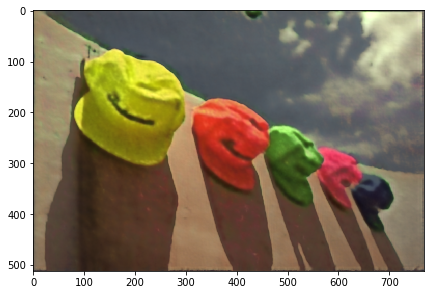

Iter # 420 , PSRN NOISY:  21.71491683227515 ; PSRN GT:  25.98703976718099


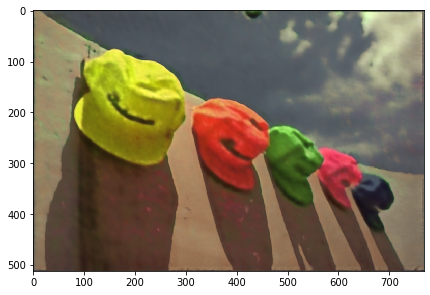

Iter # 440 , PSRN NOISY:  22.141518082757337 ; PSRN GT:  26.757703569323063


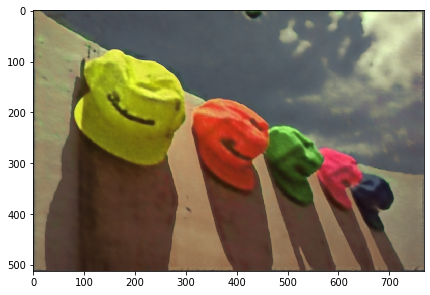

Iter # 460 , PSRN NOISY:  22.822757542303663 ; PSRN GT:  26.20980271366554


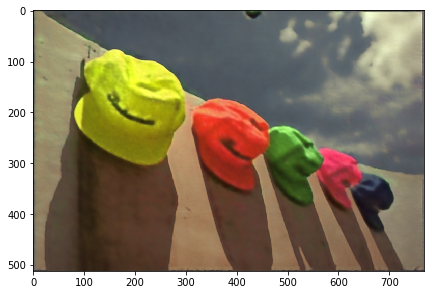

Iter # 480 , PSRN NOISY:  22.701194989402186 ; PSRN GT:  25.82579697164322


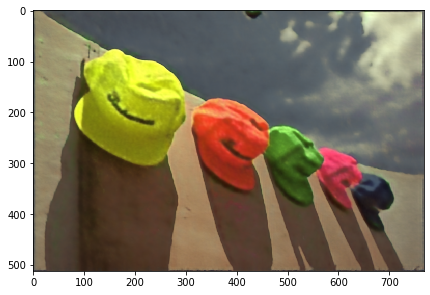

Iter # 500 , PSRN NOISY:  23.14953741695357 ; PSRN GT:  27.346580008782905


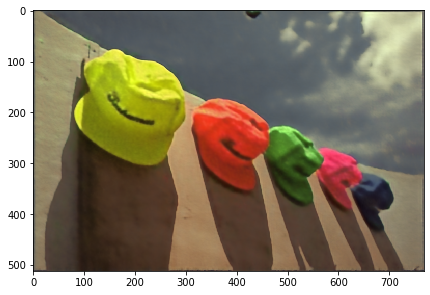

Iter # 520 , PSRN NOISY:  23.03068410756825 ; PSRN GT:  27.253907306778203


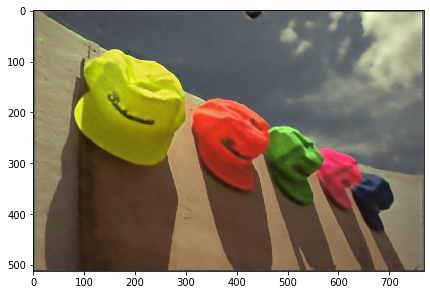

Iter # 540 , PSRN NOISY:  23.558743508029245 ; PSRN GT:  27.16083097763694


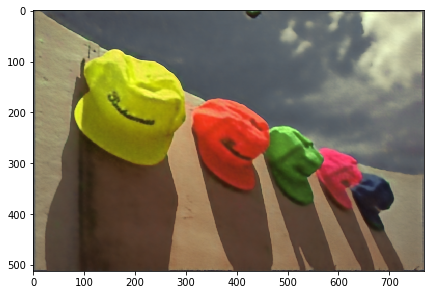

Iter # 560 , PSRN NOISY:  23.84904454827103 ; PSRN GT:  26.922421489843966


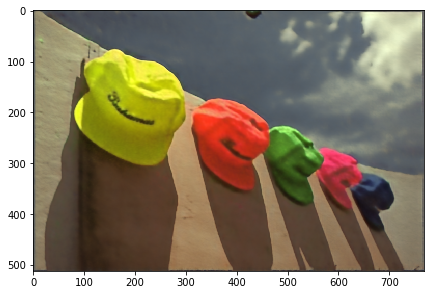

Iter # 580 , PSRN NOISY:  23.964037912556627 ; PSRN GT:  27.180855741123157


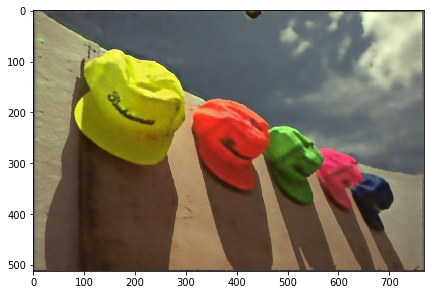

Iter # 600 , PSRN NOISY:  23.856689897420587 ; PSRN GT:  27.217280118473923


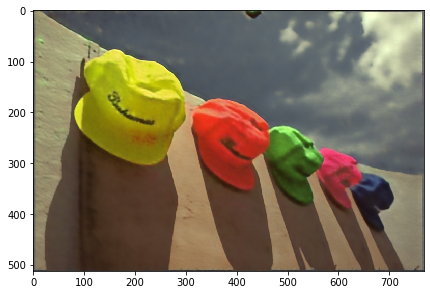

Iter # 620 , PSRN NOISY:  23.651403409021363 ; PSRN GT:  27.479264260222507


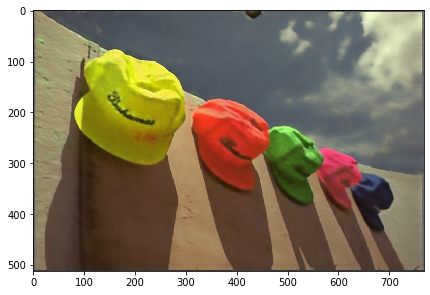

Iter # 640 , PSRN NOISY:  23.738691808685868 ; PSRN GT:  27.16154873802794


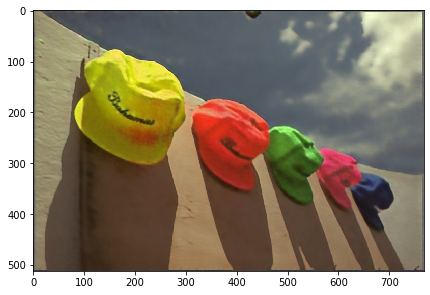

Iter # 660 , PSRN NOISY:  23.94916485135461 ; PSRN GT:  27.871716142466994


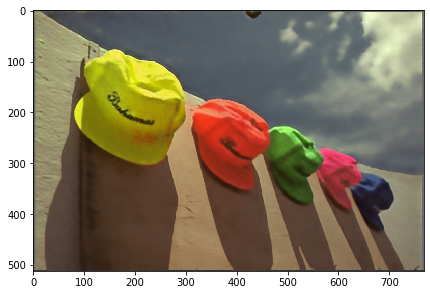

Iter # 680 , PSRN NOISY:  24.002442445571113 ; PSRN GT:  27.724776230918984


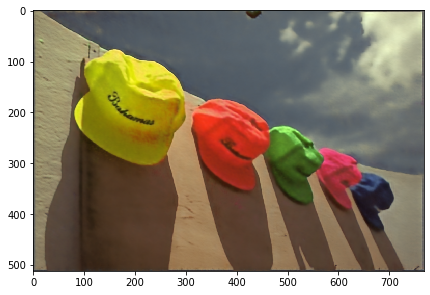

Iter # 700 , PSRN NOISY:  24.418569938485927 ; PSRN GT:  27.743590382001628


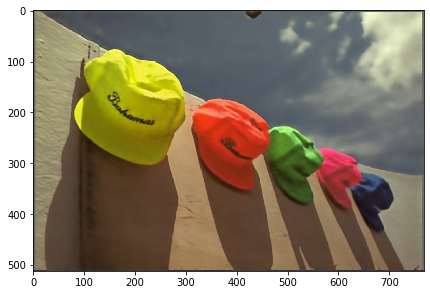

Iter # 720 , PSRN NOISY:  24.016991827389322 ; PSRN GT:  27.538307740247625


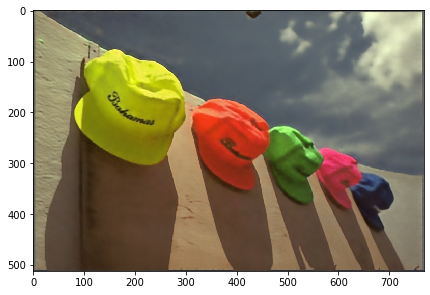

Iter # 740 , PSRN NOISY:  24.87020788156154 ; PSRN GT:  26.757075029263063


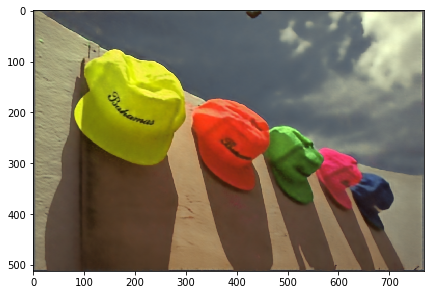

Iter # 760 , PSRN NOISY:  25.024608318127616 ; PSRN GT:  25.65124215137267


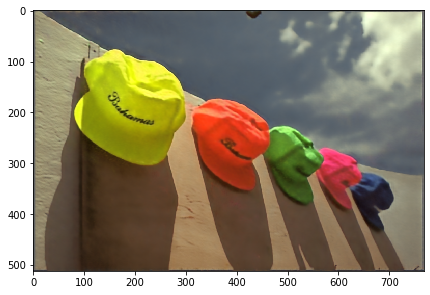

Iter # 780 , PSRN NOISY:  25.151399060660516 ; PSRN GT:  26.11577296953182


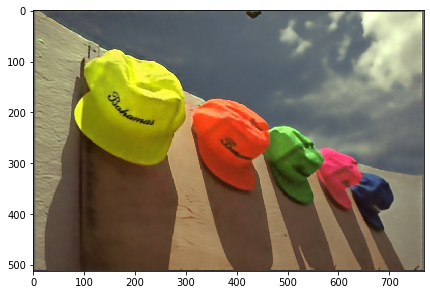

Iter # 800 , PSRN NOISY:  25.100615087143538 ; PSRN GT:  25.363237229383166


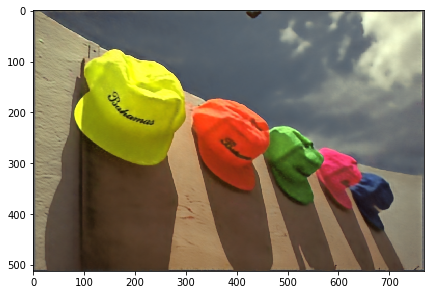

Iter # 820 , PSRN NOISY:  25.30486901726769 ; PSRN GT:  26.547801683030162


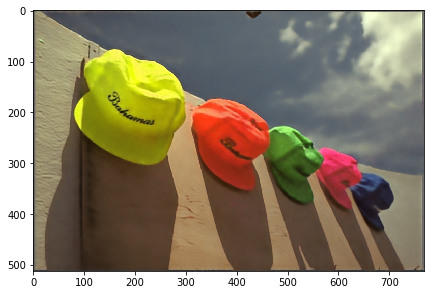

Iter # 840 , PSRN NOISY:  25.00933621661213 ; PSRN GT:  26.464791938312683


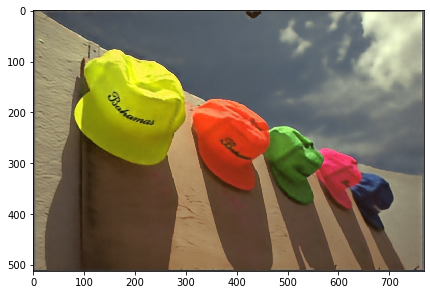

Iter # 860 , PSRN NOISY:  24.83387960035264 ; PSRN GT:  27.187827901057872


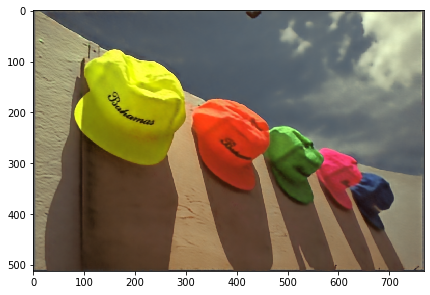

Iter # 880 , PSRN NOISY:  25.435859099547606 ; PSRN GT:  26.54542792202079


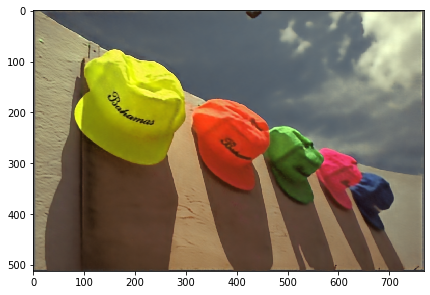

Iter # 900 , PSRN NOISY:  24.909152182441687 ; PSRN GT:  27.55883727685617


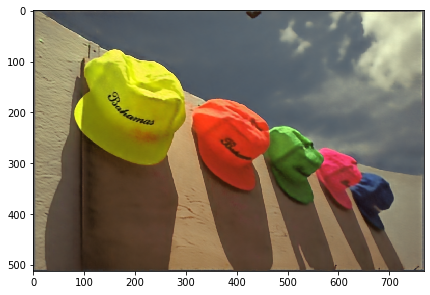

KeyboardInterrupt: 

In [14]:
for i in range(1800):
    model.train_on_batch(input_noise + np.random.normal(0, 1/30.0, (height, width, 32)), image_noisy[None, :, :, :])
    
    if i % 20 == 0:
        out = np.clip(model.predict(input_noise)[0], 0, 255).astype(np.uint8)
        cv2.imwrite("v3_kodim_out_"+str(i)+".png", out)
        
        psrn_noisy = compare_psnr(image_noisy, out) 
        psrn_gt = compare_psnr(image, out)
        print("Iter #", i, ", PSRN NOISY: ", psrn_noisy, "; PSRN GT: ", psrn_gt)
        
        plt.figure(figsize=(7, 7))
        plt.imshow(out[:,:,::-1])
        plt.show()


In [15]:
model.save("model_den_kodim.h5")